In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, roc_curve, auc, classification_report
import warnings
warnings.filterwarnings("ignore")

In [2]:
input_file = 'data/bank-full.csv'
df = pd.read_csv(input_file,sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# Preprocessing

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None


### Data Dictionary:
#### Bank client data:
1 - age (numeric)<br>
2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")<br> 
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)<br>
   4 - education (categorical: "unknown","secondary","primary","tertiary")<br>
   5 - default: has credit in default? (binary: "yes","no")<br>
   6 - balance: average yearly balance, in euros (numeric) <br>
   7 - housing: has housing loan? (binary: "yes","no")<br>
   8 - loan: has personal loan? (binary: "yes","no")<br>
   #### related with the last contact of the current campaign:
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular") <br>
  10 - day: last contact day of the month (numeric)<br>
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")<br>
  12 - duration: last contact duration, in seconds (numeric)<br>
   #### other attributes:
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)<br>
  15 - previous: number of contacts performed before this campaign and for this client (numeric)<br>
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")<br>

  #### Output variable (desired target):
  17 - y - has the client subscribed a term deposit? (binary: "yes","no")



In [4]:
#Checking for Duplicated Rows
print(f'Number of duplicated rows in the DataFrame: {df.duplicated().sum()}')

Number of duplicated rows in the DataFrame: 0


In [5]:
#Checking for Missing Values
print(df.isnull().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [6]:
print(df['y'].value_counts())

no     39922
yes     5289
Name: y, dtype: int64


In [7]:
temp = df['y'].value_counts()
print(f"Percentage of Yes - {temp[1]/len(df) * 100:.2f} %\nPercentage of No  - {temp[0]/len(df) * 100:.2f} %")

Percentage of Yes - 11.70 %
Percentage of No  - 88.30 %


- Approximately 11.70% of the instances in the dataset belong to the <b>"Yes"</b> class, indicating that a relatively small proportion of individuals subscribed to a term deposit.
- The majority, around 88.30% of instances, belong to the <b>"No"</b> class, implying that most individuals did not subscribe to a term deposit.

In [8]:
numeric_features = df.select_dtypes(include=['int64']).columns.values
categorical_features = df.select_dtypes(include=['object']).columns.values

### Feature Engineering

In [10]:
#Label Encoding
label_encoder = LabelEncoder()

In [11]:
df['default'] = label_encoder.fit_transform(df['default'])
df['housing'] = label_encoder.fit_transform(df['housing'])
df['loan'] = label_encoder.fit_transform(df['loan'])
df['y'] = label_encoder.fit_transform(df['y'])

In [12]:
#One hot Encoding
df = pd.get_dummies(df, columns = [
'job'
,'marital'
,'education'
,'contact'
,'poutcome'])

In [13]:
df = df.drop('month',axis=1)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  45211 non-null  int64
 1   default              45211 non-null  int32
 2   balance              45211 non-null  int64
 3   housing              45211 non-null  int32
 4   loan                 45211 non-null  int32
 5   day                  45211 non-null  int64
 6   duration             45211 non-null  int64
 7   campaign             45211 non-null  int64
 8   pdays                45211 non-null  int64
 9   previous             45211 non-null  int64
 10  y                    45211 non-null  int32
 11  job_admin.           45211 non-null  uint8
 12  job_blue-collar      45211 non-null  uint8
 13  job_entrepreneur     45211 non-null  uint8
 14  job_housemaid        45211 non-null  uint8
 15  job_management       45211 non-null  uint8
 16  job_retired          4

In [15]:
#Separating the features and target label
X = df.drop(columns=['y'])
y = df['y']
print(f'Dimension of our features: {X.shape}')
print(f'Dimension of our label: {y.shape}')

Dimension of our features: (45211, 36)
Dimension of our label: (45211,)


In [16]:
print(f"No.of. Negative Samples before undersampling: {len(y[y == 0])}")
print(f"No.of. Positive Samples before undersampling: {len(y[y == 1])}")

No.of. Negative Samples before undersampling: 39922
No.of. Positive Samples before undersampling: 5289


In [17]:
#Splitting and scaling Baseline without any sample
baseline_X_train, baseline_X_test, baseline_y_train, baseline_y_test = train_test_split(X, y, test_size=0.2, random_state=1011)
scaler = StandardScaler()
baseline_scaled_X_train = scaler.fit_transform(baseline_X_train)
baseline_scaled_X_test = scaler.transform(baseline_X_test)

In [18]:
baseline_model = SVC(C=1.0,kernel='rbf',verbose=True)
baseline_model.fit(baseline_scaled_X_train,baseline_y_train)
baseline_y_pred = baseline_model.predict(baseline_scaled_X_test)

[LibSVM]

In [19]:
baseline_svm_accuracy = accuracy_score(baseline_y_test, baseline_y_pred)
print("\nAccuracy for Testing Set:", baseline_svm_accuracy)

#Confusion matrix
baseline_svm_confusion_matrix_test = confusion_matrix(baseline_y_test, baseline_y_pred)

print("Confusion matrix for Testing Set:\n")
print(baseline_svm_confusion_matrix_test)

#Classfication Report
print(classification_report(baseline_y_test,baseline_y_pred))

#Precision and Recall Score
baseline_svm_precision = precision_score(baseline_y_test, baseline_y_pred)
baseline_svm_recall = recall_score(baseline_y_test, baseline_y_pred)
baseline_svm_f1 = f1_score(baseline_y_test,baseline_y_pred)
print("Precision for Testing Set:", baseline_svm_precision)
print("Recall for Testing Set:", baseline_svm_recall)
print("F1 for Testing Set:", baseline_svm_f1)


Accuracy for Testing Set: 0.899922592060157
Confusion matrix for Testing Set:

[[7844  133]
 [ 772  294]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      7977
           1       0.69      0.28      0.39      1066

    accuracy                           0.90      9043
   macro avg       0.80      0.63      0.67      9043
weighted avg       0.88      0.90      0.88      9043

Precision for Testing Set: 0.6885245901639344
Recall for Testing Set: 0.275797373358349
F1 for Testing Set: 0.39383791024782316


## Handling Class Imbalance for Baseline Model

### Undersampling

In [20]:
#NearMiss under-sampling
nm = NearMiss(version=3)
nm_X_resampled, nm_y_resampled = nm.fit_resample(X, y)

In [21]:
print(f"Shape of X after NearMiss undersampling: {nm_X_resampled.shape}")
print(f"Shape of y after NearMiss undersampling: {nm_y_resampled.shape}")
print(f"No.of. Negative Samples after NearMiss undersampling: {len(nm_y_resampled[nm_y_resampled == 0])}")
print(f"No.of. Positive Samples after NearMiss undersampling: {len(nm_y_resampled[nm_y_resampled == 1])}")

Shape of X after NearMiss undersampling: (10578, 36)
Shape of y after NearMiss undersampling: (10578,)
No.of. Negative Samples after NearMiss undersampling: 5289
No.of. Positive Samples after NearMiss undersampling: 5289


In [22]:
#Splitting and Reassigning the training and testing sets with Undersampled Data and also performing scaling
baseline_u_X_train, baseline_u_X_test, baseline_u_y_train, baseline_u_y_test = train_test_split(nm_X_resampled, nm_y_resampled, test_size=0.2, random_state=1011)
scaler = StandardScaler()
baseline_u_scaled_X_train = scaler.fit_transform(baseline_u_X_train)
baseline_u_scaled_X_test = scaler.transform(baseline_u_X_test)

In [23]:
baseline_u_svm_model = SVC(C=1.0,kernel='rbf',verbose=True)
baseline_u_svm_model.fit(baseline_u_scaled_X_train,baseline_u_y_train)
baseline_u_y_pred = baseline_u_svm_model.predict(baseline_u_scaled_X_test)

#Performance on the test set
baseline_u_svm_accuracy = accuracy_score(baseline_u_y_test, baseline_u_y_pred)
print("\nAccuracy for Testing Set:", baseline_u_svm_accuracy)

#Confusion matrix
baseline_u_svm_confusion_matrix_test = confusion_matrix(baseline_u_y_test, baseline_u_y_pred)

print("Confusion matrix for Testing Set:\n")
print(baseline_u_svm_confusion_matrix_test)

#Classfication Report
print(classification_report(baseline_u_y_test,baseline_u_y_pred))

#Precision and Recall Score
baseline_u_precision = precision_score(baseline_u_y_test, baseline_u_y_pred)
baseline_u_recall = recall_score(baseline_u_y_test, baseline_u_y_pred)
print("Precision for Testing Set:", baseline_u_precision)
print("Recall for Testing Set:", baseline_u_recall)

[LibSVM]
Accuracy for Testing Set: 0.7084120982986768
Confusion matrix for Testing Set:

[[681 337]
 [280 818]]
              precision    recall  f1-score   support

           0       0.71      0.67      0.69      1018
           1       0.71      0.74      0.73      1098

    accuracy                           0.71      2116
   macro avg       0.71      0.71      0.71      2116
weighted avg       0.71      0.71      0.71      2116

Precision for Testing Set: 0.7082251082251082
Recall for Testing Set: 0.7449908925318761


### Oversampling

In [24]:
print(f"Shape of X before oversampling: {X.shape}")
print(f"Shape of y before oversampling: {y.shape}")

Shape of X before oversampling: (45211, 36)
Shape of y before oversampling: (45211,)


In [25]:
print(f"No.of. Negative Samples before oversampling: {len(y[y == 0])}")
print(f"No.of. Positive Samples before oversampling: {len(y[y == 1])}")

No.of. Negative Samples before oversampling: 39922
No.of. Positive Samples before oversampling: 5289


In [26]:
#SMOTE (Synthetic Minority Oversampling Technique)
smote = SMOTE(random_state=1011)
smote_X_resampled, smote_y_resampled = smote.fit_resample(X, y)

In [27]:
print(f"Shape of X after Random oversampling: {smote_X_resampled.shape}")
print(f"Shape of y after Random oversampling: {smote_y_resampled.shape}")
print(f"No.of. Negative Samples after Random oversampling: {len(smote_y_resampled[smote_y_resampled == 0])}")
print(f"No.of. Positive Samples after Random oversampling: {len(smote_y_resampled[smote_y_resampled == 1])}")

Shape of X after Random oversampling: (79844, 36)
Shape of y after Random oversampling: (79844,)
No.of. Negative Samples after Random oversampling: 39922
No.of. Positive Samples after Random oversampling: 39922


In [28]:
#Splitting and Reassigning the training and testing sets with Oversampled Data and also performing scaling
baseline_o_X_train, baseline_o_X_test, baseline_o_y_train, baseline_o_y_test = train_test_split(smote_X_resampled, smote_y_resampled, test_size=0.2, random_state=2209)
scaler = StandardScaler()
baseline_o_scaled_X_train = scaler.fit_transform(baseline_o_X_train)
baseline_o_scaled_X_test = scaler.transform(baseline_o_X_test)

Best model parameters for Support Vector Machine: {'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

In [29]:
baseline_o_model = SVC(C=1.0,kernel='rbf',verbose=True)
baseline_o_model.fit(baseline_o_scaled_X_train,baseline_o_y_train)
baseline_o_y_pred = baseline_o_model.predict(baseline_o_scaled_X_test)

#Performance on the test set
baseline_o_svm_accuracy = accuracy_score(baseline_o_y_test, baseline_o_y_pred)
print("\nAccuracy for Testing Set:", baseline_o_svm_accuracy)

#Confusion matrix
baseline_o_svm_confusion_matrix_test = confusion_matrix(baseline_o_y_test, baseline_o_y_pred)

print("Confusion matrix for Testing Set:\n")
print(baseline_o_svm_confusion_matrix_test)

#Classfication Report
print(classification_report(baseline_o_y_test,baseline_o_y_pred))

#Precision and Recall Score
baseline_o_svm_precision = precision_score(baseline_o_y_test, baseline_o_y_pred)
baseline_o_svm_recall = recall_score(baseline_o_y_test, baseline_o_y_pred)
print("Precision for Testing Set:", baseline_o_svm_precision)
print("Recall for Testing Set:", baseline_o_svm_recall)

[LibSVM]
Accuracy for Testing Set: 0.9343728473918217
Confusion matrix for Testing Set:

[[7787  169]
 [ 879 7134]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7956
           1       0.98      0.89      0.93      8013

    accuracy                           0.93     15969
   macro avg       0.94      0.93      0.93     15969
weighted avg       0.94      0.93      0.93     15969

Precision for Testing Set: 0.9768588251403533
Recall for Testing Set: 0.8903032572070385


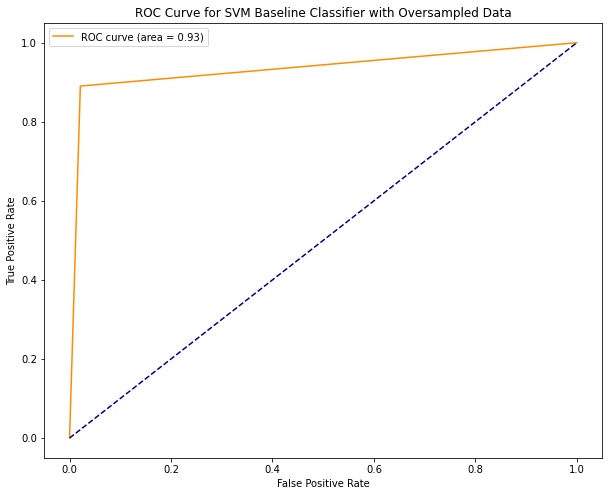

In [30]:
# ROC curve
fpr, tpr, thresholds = roc_curve(baseline_o_y_test, baseline_o_y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM Baseline Classifier with Oversampled Data')
plt.legend()
plt.savefig('ROC Curve for SVM Baseline Classifier with Oversampled Data.png')
plt.show()

## Saving the Files

In [31]:
import pickle

# Define the file path where you want to save the data
file_path = "training_data.pkl"

# Create a dictionary to store your datasets
model_data = {
    "X_train": X,
    "y_train": y,
    "X_train_smote": smote_X_resampled, 
    "y_train_smote": smote_y_resampled,
    "X_train_nearmiss": nm_X_resampled,
    "y_train_nearmiss": nm_y_resampled    
}

# Open the file in binary write mode and save the data using pickle.dump()
with open(file_path, 'wb') as file:
    pickle.dump(model_data, file)

print("Data saved successfully to:", file_path)

Data saved successfully to: training_data.pkl
